In [ ]:
!pip install unidecode
!pip install tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
import pickle
import json
import os
import math
import unidecode
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime

from collections import Counter
from math import ceil
from sklearn.model_selection import train_test_split

In [ ]:
# HuggingFace library to train a tokenizer
from tokenizers import Tokenizer, normalizers
from tokenizers.models import WordPiece
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer

### Combining the training data from 001 notebook and artificial data

In [ ]:
# All training samples that have less than 50 different version of the affiliation text
# ---- Created in previous notebook
lower_than = pd.read_parquet("lower_than_50.parquet")

# All training samples that have more than 50 different version of the affiliation text
# ---- Created in previous notebook
more_than = pd.read_parquet("more_than_50.parquet")

print(lower_than.shape)
print(more_than.shape)

(7650, 2)
(13044, 2)


In [ ]:
full_affs_data = pd.concat([more_than, lower_than],
                           axis=0).reset_index(drop=True)

In [ ]:
full_affs_data.to_parquet("full_affs_data.parquet")

In [ ]:
full_affs_data.shape

(20694, 2)

In [ ]:
full_affs_data['text_len'] = full_affs_data['original_affiliation'].apply(len)

In [ ]:
full_affs_data = full_affs_data[full_affs_data['text_len'] < 500][['original_affiliation','affiliation_id']].copy()

In [ ]:
full_affs_data.shape

(20515, 2)

In [ ]:
full_affs_data['affiliation_id'] = full_affs_data['affiliation_id'].astype('str')

### Processing and splitting the data

In [ ]:
full_affs_data['processed_text'] = full_affs_data['original_affiliation'].apply(unidecode.unidecode)

In [ ]:
train_data, val_data = train_test_split(full_affs_data, train_size=0.80, random_state=1)
train_data = train_data.reset_index(drop=True).copy()
val_data = val_data.reset_index(drop=True).copy()

In [ ]:
train_data.shape

(16412, 3)

In [ ]:
val_data.shape

(4103, 3)

In [ ]:
affs_list_train = train_data['processed_text'].tolist()
affs_list_val = val_data['processed_text'].tolist()

In [ ]:
try:
    os.system("rm aff_text.txt")
    print("Done")
except:
    pass

Done


In [ ]:
# save the affiliation text that will be used to train a tokenizer
with open("aff_text.txt", "w") as f:
    for aff in affs_list_train:
        f.write(f"{aff}\n")

In [ ]:
try:
    os.system("rm basic_model_tokenizer")
    print("Done")
except:
    pass

Done


In [ ]:
full_affs_data[['processed_text','affiliation_id']].to_parquet("full_affs_data_processed.parquet")

### Creating the tokenizer for the basic model

In [ ]:
wordpiece_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

# NFD Unicode, lowercase, and getting rid of accents (to make sure text is as readable as possible)
wordpiece_tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])

# Splitting on whitespace
wordpiece_tokenizer.pre_tokenizer = Whitespace()

# Training a tokenizer on the training dataset
trainer = WordPieceTrainer(vocab_size=3816, special_tokens=["[UNK]"])
files = ["aff_text.txt"]
wordpiece_tokenizer.train(files, trainer)

wordpiece_tokenizer.save("basic_model_tokenizer")

### Further processing of data with tokenizer

In [ ]:
def max_len_and_pad(tok_sent):
    """
    Truncates sequences with length higher than max_len and also pads the sequence
    with zeroes up to the max_len.
    """
    max_len = 128
    tok_sent = tok_sent[:max_len]
    tok_sent = tok_sent + [0]*(max_len - len(tok_sent))
    return tok_sent

def create_affiliation_vocab(x):
    """
    Checks if affiliation is in vocab and if not, adds to the vocab.
    """
    if x not in affiliation_vocab.keys():
        affiliation_vocab[x]=len(affiliation_vocab)
    return [affiliation_vocab[x]]

In [ ]:
# initializing an empty affiliation vocab
affiliation_vocab = {}

# tokenizing the training dataset
tokenized_output = []
for i in affs_list_train:
    tokenized_output.append(wordpiece_tokenizer.encode(i).ids)

train_data['original_affiliation_tok'] = tokenized_output

In [ ]:
# tokenizing the validation dataset
tokenized_output = []
for i in affs_list_val:
    tokenized_output.append(wordpiece_tokenizer.encode(i).ids)

val_data['original_affiliation_tok'] = tokenized_output

In [ ]:
# applying max length cutoff and padding
train_data['original_affiliation_model_input'] = train_data['original_affiliation_tok'].apply(max_len_and_pad)
val_data['original_affiliation_model_input'] = val_data['original_affiliation_tok'].apply(max_len_and_pad)

In [ ]:
# creating the label affiliation vocab
train_data['label'] = train_data['affiliation_id'].apply(lambda x: create_affiliation_vocab(x))

In [ ]:
len(affiliation_vocab)

328

In [ ]:
val_data['label'] = val_data['affiliation_id'].apply(lambda x: [affiliation_vocab.get(x)])

In [ ]:
train_data.to_parquet("train_data.parquet")
val_data.to_parquet("val_data.parquet")

In [ ]:
# saving the affiliation vocab
with open("affiliation_vocab.pkl","wb") as f:
    pickle.dump(affiliation_vocab, f)

### Creating TFRecords from the training and validation datasets

In [ ]:
train_data = pd.read_parquet("./train_data.parquet")

In [ ]:
val_data = pd.read_parquet("./val_data.parquet")

In [ ]:
# saving the affiliation vocab
with open("affiliation_vocab.pkl","rb") as f:
    affiliation_vocab = pickle.load(f)

In [ ]:
def create_tfrecords_dataset(data, iter_num, dataset_type='train'):
    """
    Creates a TF Dataset that can then be saved to a file to make it faster to read
    data during training and allow for transferring of data between compute instances.
    """
    ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(data['original_affiliation_model_input'].to_list()),
                              tf.data.Dataset.from_tensor_slices(data['label'].to_list())))

    serialized_features_dataset = ds.map(tf_serialize_example)

    filename = f"./training_data/{dataset_type}/{str(iter_num).zfill(4)}.tfrecord"
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_features_dataset)

In [ ]:
def tf_serialize_example(f0, f1):
    """
    Serialization function.
    """
    tf_string = tf.py_function(serialize_example, (f0, f1), tf.string)
    return tf.reshape(tf_string, ())

In [ ]:
def serialize_example(features, label):
    """
    Takes in features and outputs them to a serialized string that can be written to
    a file using the TFRecord Writer.
    """
    features_list = tf.train.Int64List(value=features.numpy().tolist())
    label_list = tf.train.Int64List(value=label.numpy().tolist())

    features_feature = tf.train.Feature(int64_list = features_list)
    label_feature = tf.train.Feature(int64_list = label_list)

    features_for_example = {
        'features': features_feature,
        'label': label_feature
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=features_for_example))

    return example_proto.SerializeToString()

In [ ]:
# Making sure data is in the correct format before going into TFRecord
train_data['original_affiliation_model_input'] = train_data['original_affiliation_model_input'] \
.apply(lambda x: np.asarray(x, dtype=np.int64))

val_data['original_affiliation_model_input'] = val_data['original_affiliation_model_input'] \
.apply(lambda x: np.asarray(x, dtype=np.int64))

In [ ]:
os.system("mkdir -p ./training_data/train/")
os.system("mkdir -p ./training_data/val/")
print("Done")

Done


#### Creating the Train Dataset

In [ ]:
%%time
for i in range(ceil(train_data.shape[0]/500000)):
    print(i)
    low = i*500000
    high = (i+1)*500000
    create_tfrecords_dataset(train_data.iloc[low:high,:], i, 'train')

0


Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


CPU times: user 8.85 s, sys: 588 ms, total: 9.44 s
Wall time: 8.35 s


#### Creating the Validation Dataset

In [ ]:
%%time
for i in range(ceil(val_data.shape[0]/60000)):
    print(i)
    low = i*60000
    high = (i+1)*60000
    create_tfrecords_dataset(val_data.iloc[low:high,:], i, 'val')

0
CPU times: user 2.35 s, sys: 157 ms, total: 2.51 s
Wall time: 2.33 s


### Loading the Data

In [ ]:
def _parse_function(example_proto):
    """
    Parses the TFRecord file.
    """
    feature_description = {
        'features': tf.io.FixedLenFeature((128,), tf.int64),
        'label': tf.io.FixedLenFeature((1,), tf.int64)
    }

    example = tf.io.parse_single_example(example_proto, feature_description)

    features = example['features']
    label = example['label'][0]

    return features, label

In [ ]:
def get_dataset(path, data_type='train'):
    """
    Takes in a path to the TFRecords and returns a TF Dataset to be used for training.
    """
    tfrecords = [f"{path}{data_type}/{x}" for x in os.listdir(f"{path}{data_type}/") if x.endswith('tfrecord')]
    tfrecords.sort()


    raw_dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=AUTO)
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=AUTO)

    parsed_dataset = parsed_dataset.apply(tf.data.experimental.dense_to_ragged_batch(512,drop_remainder=True))
    return parsed_dataset

In [ ]:
train_data_path = "./training_data/"
AUTO = tf.data.experimental.AUTOTUNE
training_data = get_dataset(train_data_path, data_type='train')
validation_data = get_dataset(train_data_path, data_type='val')

Instructions for updating:
Use `tf.data.Dataset.ragged_batch` instead.


### Load Vocab

In [ ]:
# Loading the affiliation (target) vocab
with open("affiliation_vocab.pkl","rb") as f:
    affiliation_vocab = pickle.load(f)

In [ ]:
inverse_affiliation_vocab = {i:j for j,i in affiliation_vocab.items()}

### Creating Model

In [ ]:
# Hyperparameters to tune
emb_size = 256
max_len = 128
num_layers = 6
num_heads = 8
dense_1 = 2048
dense_2 = 1024
learn_rate = 0.00004

In [ ]:
def scheduler(epoch, curr_lr):
    """
    Setting up a exponentially decaying learning rate.
    """
    rampup_epochs = 2
    exp_decay = 0.17
    def lr(epoch, beg_lr, rampup_epochs, exp_decay):
        if epoch < rampup_epochs:
            return beg_lr
        else:
            return beg_lr * math.exp(-exp_decay * epoch)
    return lr(epoch, start_lr, rampup_epochs, exp_decay)

In [ ]:
# Allow for use of multiple GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    # Model Inputs
    tokenized_aff_string_ids = tf.keras.layers.Input((128,), dtype=tf.int64, name='tokenized_aff_string_input')

    # Embedding Layers
    tokenized_aff_string_emb_layer = tf.keras.layers.Embedding(input_dim=3816,
                                                               output_dim=int(emb_size),
                                                               mask_zero=True,
                                                               trainable=True,
                                                               name="tokenized_aff_string_embedding")

    tokenized_aff_string_embs = tokenized_aff_string_emb_layer(tokenized_aff_string_ids)

    # First dense layer
    dense_output = tf.keras.layers.Dense(int(dense_1), activation='relu',
                                             kernel_regularizer='L2', name="dense_1")(tokenized_aff_string_embs)
    dense_output = tf.keras.layers.Dropout(0.20, name="dropout_1")(dense_output)
    dense_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="layer_norm_1")(dense_output)
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(dense_output)

    # Second dense layer
    dense_output = tf.keras.layers.Dense(int(dense_2), activation='relu',
                                             kernel_regularizer='L2', name="dense_2")(pooled_output)
    dense_output = tf.keras.layers.Dropout(0.20, name="dropout_2")(dense_output)
    dense_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="layer_norm_2")(dense_output)

    # Last dense layer
    final_output = tf.keras.layers.Dense(len(affiliation_vocab), activation='softmax', name='cls')(dense_output)

    model = tf.keras.Model(inputs=tokenized_aff_string_ids, outputs=final_output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate, beta_1=0.9,
                                                     beta_2=0.99),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    curr_date = datetime.now().strftime("%Y%m%d")

    filepath_1 = f"./models/{curr_date}_{dense_1}d1_{dense_2}d2/" \


    filepath = filepath_1 + "model_epoch{epoch:02d}ckpt.keras"

    # Adding in checkpointing
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                                          verbose=0, save_best_only=False,
                                                          save_weights_only=False, mode='auto',
                                                          save_freq='epoch')

    # Adding in early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4)

    start_lr = float(learn_rate)

    # Adding in a learning rate schedule to decrease learning rate in later epochs
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

    callbacks = [model_checkpoint, early_stopping, lr_schedule]


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tokenized_aff_string_inp… │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tokenized_aff_string_emb… │ (None, 128, 256)       │        976,896 │ tokenized_aff_string_… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 2048)      │        526,336 │ tokenized_aff_string_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 2048)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm_1              │ (None, 128, 2048)      │          4,096 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 128)            │              0 │ tokenized_aff_string_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 2048)           │              0 │ layer_norm_1[0][0],    │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm_2              │ (None, 1024)           │          2,048 │ dropout_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cls (Dense)               │ (None, 328)            │        336,200 │ layer_norm_2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,943,752 (15.04 MB)

 Trainable params: 3,943,752 (15.04 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [ ]:
history = model.fit(training_data, epochs=20, validation_data=validation_data, verbose=1, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 4e-05.
Epoch 1/20
     32/Unknown 512s 16s/step - loss: 24.1237 - sparse_categorical_accuracy: 0.0225

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 546s 17s/step - loss: 24.0834 - sparse_categorical_accuracy: 0.0236 - val_loss: 19.0692 - val_sparse_categorical_accuracy: 0.3631 - learning_rate: 4.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 550s 17s/step - loss: 21.6274 - sparse_categorical_accuracy: 0.3018 - val_loss: 17.3092 - val_sparse_categorical_accuracy: 0.5890 - learning_rate: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.8470812910504387e-05.
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 562s 18s/step - loss: 19.9859 - sparse_categorical_accuracy: 0.5719 - val_loss: 16.5280 - val_sparse_categorical_accuracy: 0.6790 - learning_rate: 2.8471e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4019823152490636e-05.
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 550s 17s/step - loss: 19.1196 - sparse_categorical_accuracy: 0.6747 - val_loss: 15.9866 - val_sparse_categorical_accuracy: 0.7283 - learning_rate: 2.4020e-05



In [ ]:
new_var = json.dump(str(history.history), open(f"{filepath_1}_25EPOCHS_HISTORY.json", 'w+'))
new_var

In [ ]:
# Valores finales después de la última época (época 20)
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_accuracy = history.history['sparse_categorical_accuracy'][-1]
final_val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]

print(f"Pérdida final en entrenamiento: {final_loss}")
print(f"Pérdida final en validación: {final_val_loss}")
print(f"Exactitud final en entrenamiento: {final_accuracy}")
print(f"Exactitud final en validación: {final_val_accuracy}")


Pérdida final en entrenamiento: 15.53513240814209
Pérdida final en validación: 13.91355037689209
Exactitud final en entrenamiento: 0.8931699991226196
Exactitud final en validación: 0.8404948115348816


In [ ]:
import json

# Guardar el historial del entrenamiento en un archivo JSON
with open(f"{filepath_1}_25EPOCHS_HISTORY.json", 'w+') as file:
    json.dump(history.history, file)


In [ ]:
import json

# Cargar el historial desde el archivo JSON
with open(f"{filepath_1}_25EPOCHS_HISTORY.json", 'r') as file:
    loaded_history = json.load(file)


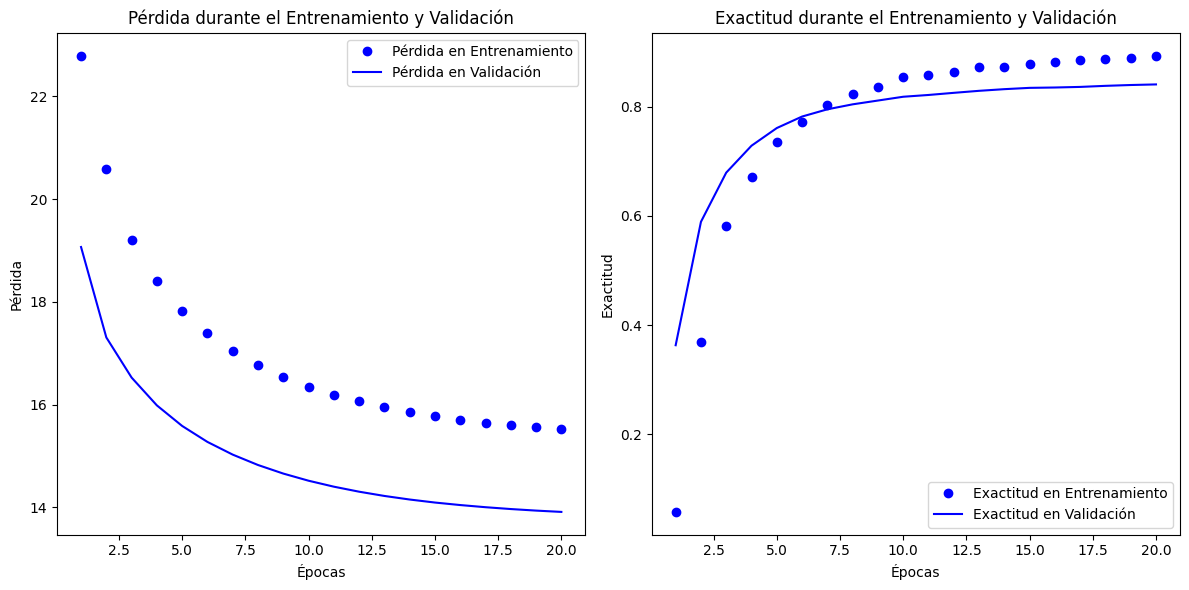

In [ ]:
import matplotlib.pyplot as plt

# Extraer los valores de las métricas del historial cargado
loss_values = loaded_history['loss']
val_loss_values = loaded_history['val_loss']
accuracy_values = loaded_history['sparse_categorical_accuracy']
val_accuracy_values = loaded_history['val_sparse_categorical_accuracy']

# Crear el rango de épocas
epochs = range(1, len(loss_values) + 1)

# Gráfico de la Pérdida (Loss)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Pérdida en Entrenamiento')
plt.plot(epochs, val_loss_values, 'b', label='Pérdida en Validación')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la Exactitud (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo', label='Exactitud en Entrenamiento')
plt.plot(epochs, val_accuracy_values, 'b', label='Exactitud en Validación')
plt.title('Exactitud durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Ejemplo de modelo simple
model = Sequential([
    Dense(64, activation='relu', input_shape=(32,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Mostrar el resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,922 (27.04 KB)

 Trainable params: 6,922 (27.04 KB)

 Non-trainable params: 0 (0.00 B)